***Step 1: Setting Up the Environment***

This step includes mounting Google Drive, installing necessary libraries, and importing them.

In [2]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell 2: Install Necessary Libraries
!pip install -q keras
!pip install -q tensorflow
!pip install -q opencv-python-headless
!pip install -q scikit-image
!pip install -q imgaug

# Cell 3: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from skimage import exposure, img_as_float
from imgaug import augmenters as iaa

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2: Loading the Dataset
Load the dataset from Kaggle or Google Drive.

(can use Kaggle API if RAM wasn't an issue. For this, uploaded data to Drive and mounted it.)

Total training images: 5712
Total training labels: 5712
Total testing images: 1311
Total testing labels: 1311


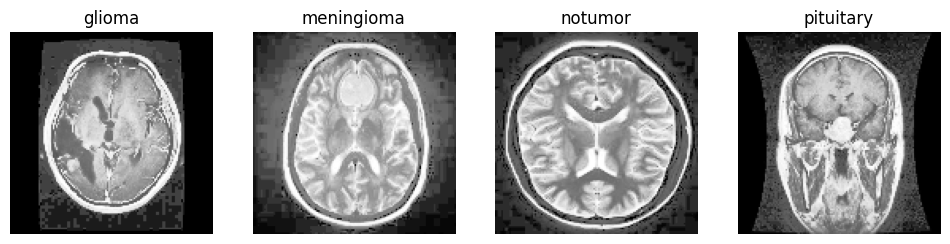

In [3]:
# Cell 4: Load Dataset
# Define the path to the dataset in ythe Google Drive
data_path = '/content/drive/MyDrive/Colab Notebooks/data'

# Function to load and preprocess images
def load_and_preprocess_data(data_dir, phase):
    images = []
    labels = []
    phase_dir = os.path.join(data_dir, phase)

    for label in os.listdir(phase_dir):
        label_dir = os.path.join(phase_dir, label)
        for file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Resize image to 128x128
            img = cv2.resize(img, (128, 128))

            # Histogram Equalisation
            img = exposure.equalize_hist(img)

            # Normalise image to range [0, 1]
            img = img / 255.0

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load and preprocess training and testing data
train_images, train_labels = load_and_preprocess_data(data_path, 'Training')
test_images, test_labels = load_and_preprocess_data(data_path, 'Testing')

# Verify the data loaded correctly
print(f'Total training images: {len(train_images)}')
print(f'Total training labels: {len(train_labels)}')
print(f'Total testing images: {len(test_images)}')
print(f'Total testing labels: {len(test_labels)}')

# Display a few sample images from each category
unique_labels = np.unique(train_labels)
plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    idx = np.where(train_labels == label)[0][0]
    plt.subplot(2, 4, i+1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.show()

***Step 3: CNN with Hybrid Attention Mechanisms***

Here we define a CNN model with integrated hybrid attention mechanisms.

In [4]:
# Cell 3: CNN with Attention Mechanisms
import tensorflow as tf
import tensorflow as keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Input, Multiply, BatchNormalization
from keras.models import Model

def attention_module(inputs):
    # Channel Attention
    gap = GlobalAveragePooling2D()(inputs)
    dense_1 = Dense(inputs.shape[-1] // 8, activation='relu')(gap)
    dense_2 = Dense(inputs.shape[-1], activation='sigmoid')(dense_1)
    channel_attention = Multiply()([inputs, dense_2])

    # Spatial Attention
    conv = Conv2D(1, (1, 1), activation='sigmoid')(inputs)
    spatial_attention = Multiply()([channel_attention, conv])

    return spatial_attention

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = attention_module(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = attention_module(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(4, activation='softmax')(x)

    model = Model(inputs, x)
    return model

input_shape = (128, 128, 1)
model = build_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['batch_normalization[0][0

***Step 4: Data Augmentation with GANs***

Generate synthetic MRI images using GANs for data augmentation.

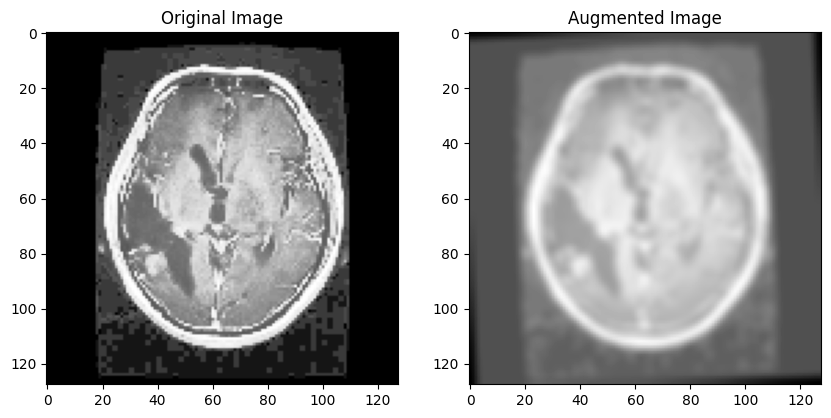

In [5]:
# Cell 4: Data Augmentation with GANs and Preprocessing
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Images are already loaded and stored in 'train_images'
# Perform histogram equalisation
equalised_images = np.array([exposure.equalize_hist(img) for img in train_images])

# Define the augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # Horizontal flips
    iaa.Affine(rotate=(-20, 20)), # Random rotations
    iaa.GaussianBlur(sigma=(0, 3.0)) # Gaussian blur
])

# Apply augmentation
augmented_images = seq(images=equalised_images)

# Display augmented example
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(equalised_images[0].squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_images[0].squeeze(), cmap='gray')
plt.show()

***Step 5: Super-Resolution using CNN***

Enhance the spatial resolution of MRI images using a simple CNN-based super-resolution model.

Epoch 1/10
143/143 [==============================] - 11s 35ms/step - loss: 0.0150 - val_loss: 0.0075
Epoch 2/10
143/143 [==============================] - 3s 22ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 3/10
143/143 [==============================] - 3s 23ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 4/10
143/143 [==============================] - 4s 25ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 5/10
143/143 [==============================] - 3s 24ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/10
143/143 [==============================] - 3s 23ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 7/10
143/143 [==============================] - 3s 22ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 8/10
143/143 [==============================] - 3s 24ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/10
143/143 [==============================] - 3s 24ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/10
179/179 [==============================] - 1s 7ms/step


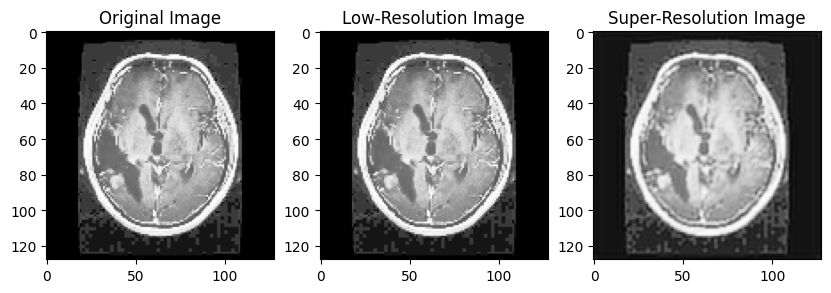

In [6]:
# Cell 5: Super-Resolution using CNN
def build_sr_model():
    input_img = Input(shape=(128, 128, 1))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, x)

# Instantiate and compile the model
sr_model = build_sr_model()
sr_model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare data for super-resolution training
x_train = np.expand_dims(equalised_images, axis=-1)
x_train_lr = np.array([cv2.resize(img, (128, 128)) for img in equalised_images])
x_train_lr = np.expand_dims(x_train_lr, axis=-1)

# Train the model
sr_model.fit(x_train_lr, x_train, epochs=10, batch_size=32, validation_split=0.2)

# Apply the model to enhance resolution
super_res_images = sr_model.predict(np.expand_dims(equalised_images, axis=-1))

# Display super-resolution example
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(equalised_images[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Low-Resolution Image')
plt.imshow(x_train_lr[0].squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Super-Resolution Image')
plt.imshow(super_res_images[0].squeeze(), cmap='gray')
plt.show()

Epoch 1/10
179/179 [==============================] - 20s 37ms/step - loss: 0.7073 - accuracy: 0.7507 - val_loss: 4.6563 - val_accuracy: 0.2334
Epoch 2/10
179/179 [==============================] - 5s 26ms/step - loss: 0.4323 - accuracy: 0.8463 - val_loss: 2.5277 - val_accuracy: 0.3089
Epoch 3/10
179/179 [==============================] - 5s 26ms/step - loss: 0.3170 - accuracy: 0.8888 - val_loss: 4.4243 - val_accuracy: 0.3089
Epoch 4/10
179/179 [==============================] - 4s 25ms/step - loss: 0.2432 - accuracy: 0.9137 - val_loss: 7.3109 - val_accuracy: 0.2334
Epoch 5/10
179/179 [==============================] - 5s 25ms/step - loss: 0.1556 - accuracy: 0.9492 - val_loss: 7.2835 - val_accuracy: 0.2586
Epoch 6/10
179/179 [==============================] - 5s 26ms/step - loss: 0.1089 - accuracy: 0.9645 - val_loss: 12.8360 - val_accuracy: 0.2288
Epoch 7/10
179/179 [==============================] - 4s 25ms/step - loss: 0.0947 - accuracy: 0.9708 - val_loss: 17.3369 - val_accuracy: 0.2

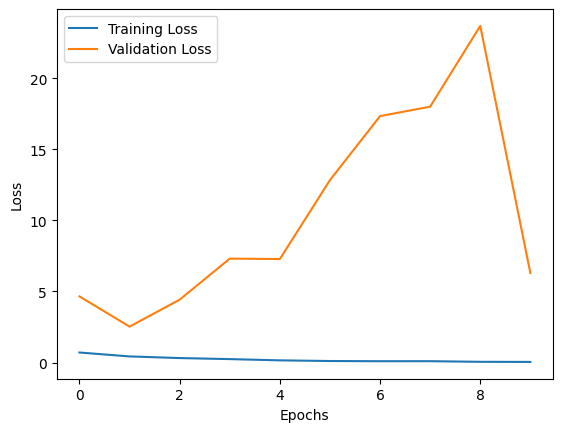

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Reshape images to add channel dimension (if not already done)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Train the model and capture the history
history = model.fit(augmented_images, train_labels_encoded, epochs=10, batch_size=32, validation_data=(test_images, test_labels_encoded))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels_encoded)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

***Step 6: Noise Reduction with Deep Learning***

Reduce noise in MRI images using a convolutional autoencoder.

Epoch 1/10
143/143 [==============================] - 10s 48ms/step - loss: 0.5895 - val_loss: 0.5686
Epoch 2/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5783 - val_loss: 0.5643
Epoch 3/10
143/143 [==============================] - 5s 36ms/step - loss: 0.5761 - val_loss: 0.5608
Epoch 4/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5746 - val_loss: 0.5603
Epoch 5/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5736 - val_loss: 0.5583
Epoch 6/10
143/143 [==============================] - 5s 36ms/step - loss: 0.5730 - val_loss: 0.5575
Epoch 7/10
143/143 [==============================] - 5s 38ms/step - loss: 0.5725 - val_loss: 0.5569
Epoch 8/10
143/143 [==============================] - 5s 37ms/step - loss: 0.5720 - val_loss: 0.5573
Epoch 9/10
143/143 [==============================] - 5s 36ms/step - loss: 0.5717 - val_loss: 0.5565
Epoch 10/10
179/179 [==============================] - 2s 11ms/step


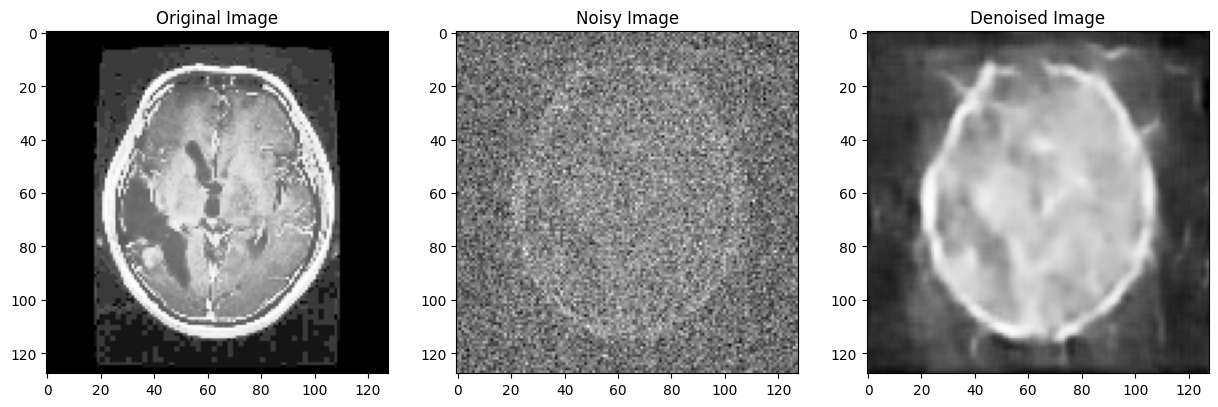

In [8]:
# Cell 6: Noise Reduction with Deep Learning
def build_denoising_autoencoder():
    input_img = Input(shape=(128, 128, 1))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

# Instantiate and compile the model
denoising_autoencoder = build_denoising_autoencoder()
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Add noise to the images
noisy_images = equalised_images + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=equalised_images.shape)

# Train the model
denoising_autoencoder.fit(np.expand_dims(noisy_images, axis=-1), np.expand_dims(equalised_images, axis=-1), epochs=10, batch_size=32, validation_split=0.2)

# Apply the model to denoise images
denoised_images = denoising_autoencoder.predict(np.expand_dims(noisy_images, axis=-1))

# Display denoised example
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(equalised_images[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_images[0], cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_images[0].squeeze(), cmap='gray')
plt.show()

***Step 7: Feature Extraction with Wavelet Transformations***

Apply wavelet transformations to extract features from MRI images.

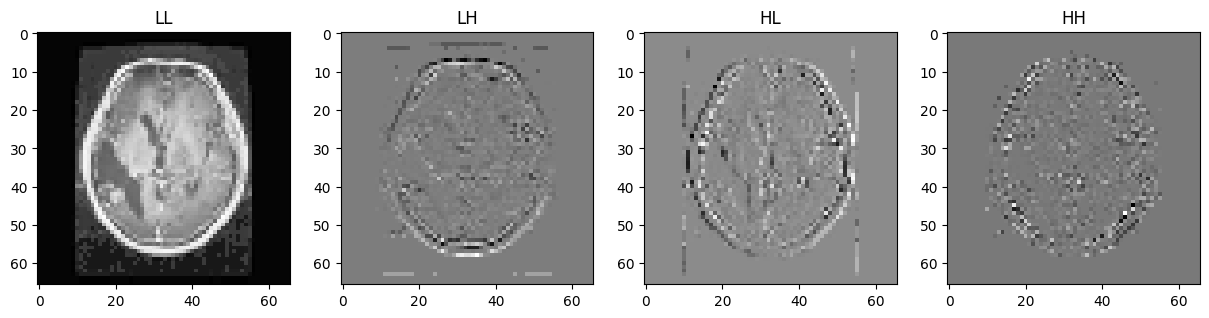

In [9]:
# Cell 7: Feature Extraction with Wavelet Transformations
import pywt

def wavelet_transform(image):
    coeffs2 = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH

# Apply wavelet transform
wavelet_features = [wavelet_transform(img) for img in equalised_images]

# Display wavelet features
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.title('LL')
plt.imshow(wavelet_features[0][0], cmap='gray')
plt.subplot(1, 4, 2)
plt.title('LH')
plt.imshow(wavelet_features[0][1], cmap='gray')
plt.subplot(1, 4, 3)
plt.title('HL')
plt.imshow(wavelet_features[0][2], cmap='gray')
plt.subplot(1, 4, 4)
plt.title('HH')
plt.imshow(wavelet_features[0][3], cmap='gray')
plt.show()

***Step 8: Combining Pre-processed Data***

Combine all pre-processed data into a single dataset for further analysis and model training.

In [10]:
# Cell 8: Combine Pre-processed Data
# Stack all pre-processed images together
combined_images = np.stack([equalised_images, augmented_images, super_res_images.squeeze(), denoised_images.squeeze()], axis=0)

# Flatten the stack for model training
combined_images = combined_images.reshape(-1, 128, 128, 1)

# Verify the shape of the combined dataset
print(f'Combined dataset shape: {combined_images.shape}')

Combined dataset shape: (22848, 128, 128, 1)


***Step 9: Model Training and Evaluation***

Train the model on the augmented training data and evaluate its performance.

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming train_images is already loaded and preprocessed
# If train_images is not yet expanded, expand dimensions
if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)
if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)

# Create the train data generator
train_generator = train_datagen.flow(train_images, train_labels_encoded, batch_size=32)

# Train the model using the augmented data generator
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=(test_images, test_labels_encoded)
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels_encoded)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
179/179 [==============================] - 12s 63ms/step - loss: 1.0760 - accuracy: 0.5455 - val_loss: 200.5418 - val_accuracy: 0.2288
Epoch 2/10
179/179 [==============================] - 12s 70ms/step - loss: 0.9179 - accuracy: 0.6087 - val_loss: 94.2030 - val_accuracy: 0.2288
Epoch 3/10
179/179 [==============================] - 12s 68ms/step - loss: 0.8907 - accuracy: 0.6222 - val_loss: 4.0072 - val_accuracy: 0.4119
Epoch 4/10
179/179 [==============================] - 12s 67ms/step - loss: 0.8519 - accuracy: 0.6502 - val_loss: 2.9147 - val_accuracy: 0.4279
Epoch 5/10
179/179 [==============================] - 12s 66ms/step - loss: 0.7998 - accuracy: 0.6724 - val_loss: 4.8040 - val_accuracy: 0.2799
Epoch 6/10
179/179 [==============================] - 12s 67ms/step - loss: 0.7772 - accuracy: 0.6805 - val_loss: 4.2972 - val_accuracy: 0.3410
Epoch 7/10
179/179 [==============================] - 10s 57ms/step - loss: 0.7374 - accuracy: 0.7045 - val_loss: 8.3699 - val_accura

***Step 10: Explainability with Grad-CAM***

Use Grad-CAM to visualise which parts of the image the model focuses on during classification.

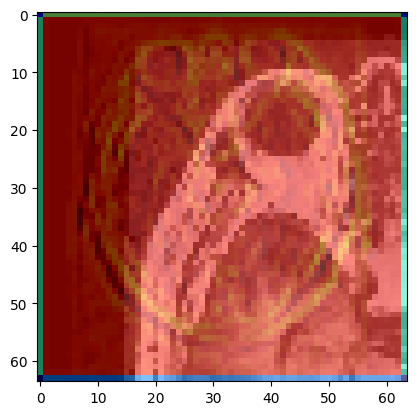

In [12]:
# Cell 10: Explainability with Grad-CAM
import keras.backend as K
import matplotlib.pyplot as plt

def grad_cam(model, img, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = np.mean(conv_outputs[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Visualise Grad-CAM for an example image
layer_name = 'conv2d_2'  # Specify the name of the last convolutional layer
img = test_images[0]
heatmap = grad_cam(model, img, layer_name)

plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.show()